# DCTによる圧縮画像を作る(LENNA編)

In [1]:
import numpy as np
import scipy.misc
from scipy.fftpack import dct, idct
import sys
from PIL import Image
import matplotlib
import matplotlib.pyplot as plt
import random
from tqdm import tqdm_notebook as tqdm
from scipy.fftpack import dct, idct
import seaborn as sns

%matplotlib inline


class ImageLoader:
    def __init__(self, FILE_PATH):
        self.img = np.array(Image.open(FILE_PATH))
        # 行数
        self.row_blocks_count = self.img.shape[0] // 8
        # 列数
        self.col_blocks_count = self.img.shape[1] // 8

    def get_points(self, POINT):
        Row = random.randint(0, len(self.img) - POINT - 1)
        Col = random.randint(0, len(self.img) - 1)
        return self.img[Row : Row + POINT, Col]


# plt.rcParams['font.family'] ='sans-serif'#使用するフォント
# plt.rcParams["font.sans-serif"] = "Source Han Sans"
plt.rcParams["font.family"] = "Source Han Sans JP"  # 使用するフォント
plt.rcParams["xtick.direction"] = "in"  # x軸の目盛線が内向き('in')か外向き('out')か双方向か('inout')
plt.rcParams["ytick.direction"] = "in"  # y軸の目盛線が内向き('in')か外向き('out')か双方向か('inout')
plt.rcParams["xtick.major.width"] = 1.0  # x軸主目盛り線の線幅
plt.rcParams["ytick.major.width"] = 1.0  # y軸主目盛り線の線幅
plt.rcParams["font.size"] = 12  # フォントの大きさ
plt.rcParams["axes.linewidth"] = 1.0  # 軸の線幅edge linewidth。囲みの太さ
matplotlib.font_manager._rebuild()

# 画像の用意
AIRPLANE = ImageLoader("../../Mono/airplane512.bmp")
BARBARA = ImageLoader("../../Mono/BARBARA.bmp")
BOAT = ImageLoader("../../Mono/BOAT.bmp")
BRIDGE = ImageLoader("../../Mono/BRIDGE.bmp")
BUILDING = ImageLoader("../../Mono/Building.bmp")
CAMERAMAN = ImageLoader("../../Mono/Cameraman.bmp")
GIRL = ImageLoader("../../Mono/girl.bmp")
LAX = ImageLoader("../../Mono/LAX.bmp")
LENNA_256 = ImageLoader("../../Mono/LENNA.bmp")
LENNA_512 = ImageLoader("../../Mono/lenna512.bmp")
LIGHTHOUSE = ImageLoader("../../Mono/Lighthouse.bmp")
SIDBAtitle = ImageLoader("../../Mono/SIDBAtitle256.bmp")
TEXT = ImageLoader("../../Mono/Text.bmp")
WOMAN = ImageLoader("../../Mono/WOMAN.bmp")

Images = np.array(
    [
        AIRPLANE,
        BARBARA,
        BOAT,
        BRIDGE,
        BUILDING,
        CAMERAMAN,
        GIRL,
        LAX,
        LENNA_256,
        LENNA_512,
        LIGHTHOUSE,
        SIDBAtitle,
        TEXT,
        WOMAN,
    ]
)

N = 8

# DCT

## 基底関数

$$
\phi_k[i] = \begin{cases}
\cfrac{1}{\sqrt{N}}  \quad \quad \quad (k=0) \\
\sqrt{\cfrac{2}{N}} \cos \left({\cfrac{\pi}{2N}(2i+1)k}\right) \quad  (k=1,2,...,N-1) 
\end{cases}
$$

In [2]:
class DCT:
    def __init__(self, N):
        self.N = N  # データ数
        # 1次元DCTの基底ベクトルの生成
        self.phi_1d = np.array([self.phi(i) for i in range(self.N)])
        # 2次元DCTの基底ベクトルの格納
        self.phi_2d = np.zeros((N, N))

    def phi(self, k):
        """ 離散コサイン変換(DCT)の基底関数 """
        # DCT-II
        if k == 0:
            return np.ones(self.N) / np.sqrt(self.N)
        else:
            return np.sqrt(2.0 / self.N) * np.cos(
                (k * np.pi / (2 * self.N)) * (np.arange(self.N) * 2 + 1)
            )

    def dct(self, data):
        """ 1次元離散コサイン変換を行う """
        return self.phi_1d.dot(data)

    def idct(self, c):
        """ 1次元離散コサイン逆変換を行う """
        return np.sum(self.phi_1d.T * c, axis=1)

    def get_dct2_phi(self, y, x):
        """ 2次元離散コサイン変換の基底を返す """
        phi_x, phi_y = np.meshgrid(self.phi_1d[x], self.phi_1d[y])
        return phi_x * phi_y

    def get_dct2(self, y, x, data):
        """ i,jの2次元DCT係数を返す """
        phi_2d_phi = np.zeros((self.N, self.N))
        phi_2d_phi = self.get_dct2_phi(y, x)
        return np.sum(np.sum(phi_2d_phi * data))

    def dct2(self, data):
        """ 2次元離散コサイン変換を行う """
        for y in range(self.N):
            for x in range(self.N):
                self.phi_2d[y, x] = self.get_dct2(y, x, data)

        return self.phi_2d

    def idct2(self, c):
        """ 2次元離散コサイン逆変換を行う """
        idct2_data = np.zeros((self.N, self.N))
        phi_2d_phi = np.zeros((self.N, self.N))
        for y in range(self.N):
            for x in range(self.N):
                phi_2d_phi = self.get_dct2_phi(y, x)
                idct2_data += c[y,x] * phi_2d_phi

        return idct2_data

# 8x8ブロックでDCT

## LENNA

### DCT

In [3]:
IMG = LENNA_256

In [4]:
Fk = np.zeros(IMG.img.shape)

In [5]:
dct = DCT(N)
for i in range(IMG.img.shape[0] // 8):
    for j in range(IMG.img.shape[1] // 8):
        block = IMG.img[i * 8 : (i + 1) * 8, j * 8 : (j + 1) * 8]
        c = dct.dct2(block)
        #         c = scipy.fftpack.dct(
        #             scipy.fftpack.dct(block, axis=0, norm="ortho"), axis=1, norm="ortho"
        #         )
        Fk[8 * i : 8 * i + 8, 8 * j : 8 * j + 8] = c

# 量子化テーブル

In [6]:
Q50_Luminance = np.array(
    [
        [16, 11, 10, 16, 24, 40, 51, 61],
        [12, 12, 14, 19, 26, 58, 60, 55],
        [14, 13, 16, 24, 40, 57, 69, 56],
        [14, 17, 22, 29, 51, 87, 80, 62],
        [18, 22, 37, 56, 68, 109, 103, 77],
        [24, 35, 55, 64, 81, 104, 113, 92],
        [49, 64, 78, 87, 103, 121, 120, 101],
        [72, 92, 95, 98, 112, 100, 103, 99],
    ]
)

$$
S = (Q < 50)?\frac{5000}{Q}:200-2Q\\
Q_s[i] = \left[\frac{S\times Q_b[i]+50}{100}\right]
$$

In [7]:
# Q=80における量子化テーブルをスケーリング
Q = 80
if Q < 50:
    S = 5000 / Q
else:
    S = 200 - 2 * Q

S = np.floor(S)

Q_Luminance = np.zeros((8, 8))
Q_Chrominance = np.zeros((8, 8))
for i in range(8):
    for j in range(8):
        Q_Luminance[i, j] = np.floor((S * Q50_Luminance[i, j] + 50) / 100)

In [8]:
# for i in range(IMG.img.shape[0] // 8):
#     for j in range(IMG.img.shape[1] // 8):
#         block = Fk[i * 8 : (i + 1) * 8, j * 8 : (j + 1) * 8]
#         # 量子化
#         block = np.round(block / Q_Luminance)
#         # 逆量子化
#         block = np.round(block * Q_Luminance)
#         Fk[8 * i : 8 * i + 8, 8 * j : 8 * j + 8] = block

In [9]:
low_3_value = 0
others_value = 0

In [10]:
for row in range(IMG.img.shape[0] // 8):
    for col in range(IMG.img.shape[1] // 8):
        block = Fk[row * 8 : (row + 1) * 8, col * 8 : (col + 1) * 8]
        low_3_value += np.abs(block[0, 1]) + np.abs(block[1, 0]) + np.abs(block[1, 1])
        others_value += (
            np.sum(np.sum(np.abs(block)))
            - np.abs(block[0, 0])
            - np.abs(block[0, 1])
            - np.abs(block[1, 0])
            - np.abs(block[1, 1])
        )

### 低域3成分 (0,1)(1,0)(1,1)の絶対値の和

In [11]:
low_3_value

140767.51818221962

In [12]:
others_value

376378.6632515169

### IDCT

In [13]:
recover = np.zeros(Fk.shape)

In [14]:
dct = DCT(N)
for i in range(Fk.shape[0] // 8):
    for j in range(Fk.shape[1] // 8):
        block = Fk[i * 8 : i * 8 + 8, j * 8 : j * 8 + 8]
        data = dct.idct2(block)
        #         data = scipy.fftpack.idct(
        #             scipy.fftpack.idct(block, axis=0, norm="ortho"), axis=1, norm="ortho"
        #         )
        recover[8 * i : 8 * i + 8, 8 * j : 8 * j + 8] = data

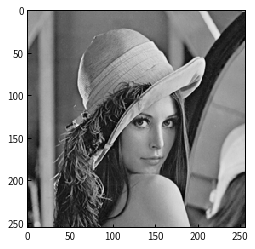

In [15]:
plt.imshow(recover, cmap="gray")
plt.imsave("lenna.bmp", recover, cmap="gray")

In [16]:
recover[0, 0:10]

array([162., 162., 162., 163., 164., 161., 155., 159., 157., 161.])

In [17]:
IMG.img[0, 0:10]

array([162, 162, 162, 163, 164, 161, 155, 159, 157, 161], dtype=uint8)

ちゃんと復元できてる

In [18]:
Original = IMG.img.copy()
np.sum(np.sum(np.abs(Original - np.round(recover))))

0.0

In [19]:
np.savetxt("../../temp/hiro_ori_dct.csv", Fk)

In [20]:
c = np.array([[1,2,3],[4,5,6],[7,8,9]])

In [21]:
d = np.array([[1,2,3],[4,5,6],[7,8,9]])

In [22]:
d[0,1] * c

array([[ 2,  4,  6],
       [ 8, 10, 12],
       [14, 16, 18]])